# Introdution to Neural Network

It is based on Andrej's fantastic Youtube video [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0).

It explains how deep neural network (DNN) works under the hood.

## Introduction

Autgrad means automatic gradient. It implements backprogpation algorithm that is used to efficiently 

- evaluate the gradient of 
- a loss function with respect to 
- the weights of 
- a neural network.

It improves the NN accuracy by iteratively tuning the weights of the neural network to minize the loss function.

Backpropagation is the mathematical core of a DNN library like `PyTorch`.

Let's see a simple lib named [Micrograd](https://github.com/karpathy/micrograd).

### Backpropagation

A calcuation can be expressed as a series of expressions. For example: 

```python
c = a + b
d = a + b * b ** 3
e = c - d
g = e ** 2
```

`g.backward()` is the backpropagation. It starts at `g`, goes backward through its expression graph and recursively applies the calculus chain rule to evaluate the partial derivative of `g` with respect to the all internal nodes (`e`, `d`, and `c`) and inputs (`a` and `b`). The derivatives are stores in the `.grad` attribute of each value.

A derivative tells how a value affects the expression result. It is the slope of growth of the value with regard to the result.

Though this made-up expression doesn't mean anything, it shows how deep neural network works. DNN are just mathematic expressions like this one.

### DNN

- A DNN is just a certain type of mathematic expression.
- The inputs for a DNN include input values and weights of DNN.
- The outpuf of a DNN is prediction or a loss function.

For pedagogical reasons, Microgradworks on scalar values. A typical DNN works on multi-dimension data (called `tensor`s in PyTorch) for effecient parallel computation. They are fundmentaly the same thing.

Micrograd has an autograd engine `engine.py` that has less than 100 lines of Python code. The `nn.py` defines a DNN consists of `Neuron`, `Layer` and `MLP`. It only has 60 lines of Python code. 

That's enough to understand how DNN training works.

## The Engine Code

To run the deom code, please install Python libraries

```sh
pip install jupyter # for Jupyter Notebook
pip install numpy matplotlib pandas seaborn statsmodels # for computation and visualization
pip install graphviz # build expression graph
```

You also need to install `graphviz` application in your OS.
In MacOS, it might be `brew install graphviz`. 

In [64]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [156]:
class Value:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def backward(self):

        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [157]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
d = a * b
d.label = "d"
L = c + d
L.label = "L"
L

Value(data=4.0)

In [147]:
from graphviz import Digraph


def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad),
            shape="record",
        )
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

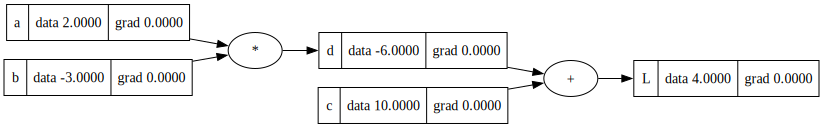

In [148]:
draw_dot(L)

## The Derivative Chain Rule

![img](../images/chain-rule.jpg)

The derivative of the composite function is the inner function ‍ within the derivative of the outer function, multiplied by the derivative of the inner function.

A [Wikipedia example](https://en.wikipedia.org/wiki/Chain_rule): 
> If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 × 4 = 8 times as fast as the man."

In [69]:
def backward(self):

    topo = []
    visited = set()

    def build_topo(v):
        if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)

    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
        node._backward()

In [70]:
def __add__(self, other):
    out = Value(self.data + other.data, (self, other), "+")

    def _backward():
        self.grad += 1.0 * out.grad
        other.grad += 1.0 * out.grad

    out._backward = _backward

    return out

In [71]:
def __mul__(self, other):
    # to allow for scalar multiplication
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), "*")

    def _backward():
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad

    out._backward = _backward

    return out

### A Neuron

A neuron is an expression with several inputs and one bias.
It creates one ouptut.

For example: a partial neuron with two inputs can be expressed as 

`output = input_1 * weight_1 + input_2 * weight_2 + bias`

Weights and bais are **parameters**. 

It is partial because it misses a non-linear transformation - described later.

In [192]:
# a neuron with two inputs and one output
# inputs x1,x2
x1 = Value(2.0, label="x1")
x2 = Value(1.5, label="x2")
# weights w1,w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias of the neuron
b = Value(6.8813735870195432, label="b")

# x1w1 = x1 * w1
# x2w2 = x2 * w2
# ws = x1w1 + x2w2
# o = ws + b

o = (x1 * w1 + x2 * w2) + b

print(f"output: {o.data:.4f}")
o.backward()

print("---")
print("w1 grad", w1.grad)
print("w2 grad", w2.grad)
print("b grad", b.grad)

output: 2.3814
---
w1 grad 2.0
w2 grad 1.5
b grad 1.0


### Computation Goal

If the computation goal is a loss function value that we want to minimize.
If the goal is to maximize a value, just change the ajustment direction,or negate the goal value to make it a minimization goal.

With `step_rate`, adjust parameters (weights and biases) because the inputs ar given.

- Decrease a value's weight if its gradient is positive:
    - `v.weight -= step_rate * v.gradient`
- Increase a value's weight if its gradient is negative:
  - `v.weight -= step * v.gradient`

In [188]:
step_rate = 0.01
w1.data -= step_rate * w1.grad
w2.data -= step_rate * w2.grad
b.data -= step_rate * b.grad

o = x1 * w1 + x2 * w2 + b

print(f"output: {o.data:.4f}")
print("---")
print("w1", w1)
print("w2", w2)
print("b", b)

output: 1.5839
---
w1 Value(data=-3.22)
w2 Value(data=0.8349999999999999)
b Value(data=6.7713735870195455)


## The PyTorch Library

PyTorch is a framework for building deep learning models.

The `Value` class uses the PyTorch API for its data element.

`pip3 install torch torchvision`

In [191]:
import torch

x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([1.5]).double()
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()
b.requires_grad = True
n = x1 * w1 + x2 * w2 + b

print(n.data.item())
n.backward()

print("---")
print("x2", x2.grad.item())
print("w2", w2.grad.item())
print("x1", x1.grad.item())
print("w1", w1.grad.item())

2.381373405456543
---
x2 1.0
w2 1.5
x1 -3.0
w1 2.0


## MLP: Multi-Layer Perceptron

![img](../images/single-and-mlp.png)

Source: https://www.pycodemates.com/2023/01/multi-layer-perceptron-a-complete-overview.html

### Weights and Bias

![img](../images/weights-and-bias.png)

![img](../images/formula.png)

Source: https://www.pycodemates.com/2023/01/multi-layer-perceptron-a-complete-overview.html

### Neuron (Finally)

The design of Neuron follows th PyTorch API based on a pupolar conceptaul DNN model.

- A neuron has a number of inputs and a bias.
    - Each input `x` has a weight `w`. 
    - The input weights and the bias are **parameters**. 
    - All are initialized with random numbers.
- A neuron has one output that 
    - First, add the `bias` and the weighted sum of input: the `dot` product of `W` (all weights) and `X` (all inputs). The result is `z = WX + bias`.
    - Second, the sum is transformed by an activation function like `tanh` or `relu` (Rectified Linear Unit) to make it can handle complex non-linear relationships. Otherwise, the result is a simple linear transformation that is far from enough for real world knowledge.
    - The final output value is `tanh(WX + bias)` or `relu(WX + bias)`.

### Activation Function

In NN, activation function is used to transform input data to a desired one. Common activation functions include `Sigmoid`, `tanh` and `relu`. `relu` becomes popular due to its computational efficiency.

![img](../images/tanh.webp)

Source: https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6

###  `relu`

```python
# method of class Value
def relu(self):
    out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

    def _backward():
        self.grad += (out.data > 0) * out.grad

    out._backward = _backward
    return out
```

![img](../images/relu.png)
Source: https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/

In [193]:
class Value:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(
            other, (int, float)
        ), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward

        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __truediv__(self, other):  # self / other
        return self * other**-1

    def __neg__(self):  # -self
        return self * -1

    def __sub__(self, other):  # self - other
        return self + (-other)

    def __radd__(self, other):  # other + self
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), "exp")

        def _backward():
            self.grad += (
                out.data * out.grad
            )  # NOTE: in the video I incorrectly used = instead of +=. Fixed here.

        out._backward = _backward

        return out

    def backward(self):

        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [ ]:
from graphviz import Digraph


def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad),
            shape="record",
        )
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [194]:
import random


class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

In [195]:
x = [2.0, 3.0]
neuron = Neuron(2)
print(neuron.parameters())
out = neuron(x)
print(out.data)
out.backward()
print(neuron.w[0].grad, neuron.w[1].grad, neuron.b.grad)

[Value(data=0.3633418870389822), Value(data=-0.39234874210650883), Value(data=-0.7974124463376258)]
-0.8476585095276508
0.5629501024507233 0.844425153676085 0.28147505122536165


### Layer

- A `Layer` has a number of `Neuron`s, each `Neuron is fully connected to all inputs.
- Each `Neuron` evaluates its inputs independently.
- It has a number of outputs

In [196]:
class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

In [197]:
x = [2.0, 3.0]
layer = Layer(2, 3)
out = layer(x)
print(out)

[Value(data=0.9091340080833454), Value(data=-0.07118696975622546), Value(data=-0.9977044495276088)]


### MLP

A MLP has many layers that whose inputs and outputs are connected between two layers.

In [78]:
class MLP:
    # nin is the number of input neurons
    # nouts is a list of number of neurons in each layer
    def __init__(self, nin, nouts):
        layer_sizes = [nin] + nouts
        layer_range = range(len(nouts))
        self.layers = [Layer(layer_sizes[i], layer_sizes[i + 1]) for i in layer_range]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)
# draw_dot(n(x))